In [ ]:
# to run in google colab
import sys

if "google.colab" in sys.modules:
    import subprocess

    subprocess.call("apt-get install subversion".split())
    subprocess.call("svn export https://github.com/YoniChechik/AI_is_Math/trunk/c_07_camera_calibration/images".split())




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt



In [ ]:
square_size = 2.50
img_mask = "/content/images/*.jpg"
pattern_size = (8, 6)

figsize = (19.7, 21.0)


In [ ]:

img_names = glob(img_mask)
num_images = len(img_names)

pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)
pattern_points *= square_size

obj_points = []
img_points = []
h, w = cv2.imread(img_names[0]).shape[:2]



processing /content/images/1.jpg... 
/content/images/1.jpg... OK
processing /content/images/3.jpg... 
/content/images/3.jpg... OK
processing /content/images/2.jpg... 
/content/images/2.jpg... OK
processing /content/images/4.jpg... 
/content/images/4.jpg... OK
processing /content/images/5.jpg... 
/content/images/5.jpg... OK


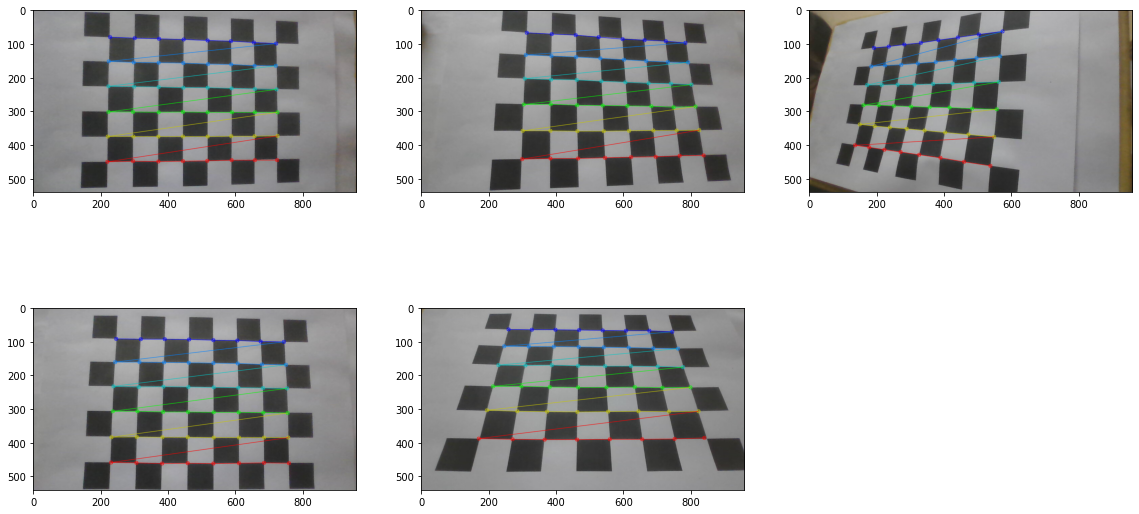

In [ ]:
plt.figure(figsize=figsize)

for i, fn in enumerate(img_names):
    print("processing %s... " % fn)
    imgBGR = cv2.imread(fn)

    if imgBGR is None:
        print("Failed to load", fn)
        continue

    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2GRAY)

    assert w == img.shape[1] and h == img.shape[0], f"size: {img.shape[1]} x {img.shape[0]}"
    found, corners = cv2.findChessboardCorners(img, pattern_size)
    # # if you want to better improve the accuracy... cv2.findChessboardCorners already uses cv2.cornerSubPix
    # if found:
    #     term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)
    #     cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)

    if not found:
        print("chessboard not found")
        continue

    if i < 12:
        img_w_corners = cv2.drawChessboardCorners(imgRGB, pattern_size, corners, found)
        plt.subplot(4, 3, i + 1)
        plt.imshow(img_w_corners)

    print(f"{fn}... OK")
    img_points.append(corners.reshape(-1, 2))
    obj_points.append(pattern_points)


plt.show()



In [ ]:
# calculate camera distortion
rms, camera_matrix, dist_coefs, _rvecs, _tvecs = cv2.calibrateCamera(obj_points, img_points, (w, h), None, None)

print("\nRMS:", rms)
print("camera matrix:\n", camera_matrix)
print("distortion coefficients: ", dist_coefs.ravel())




RMS: 1.4807127138486573
camera matrix:
 [[698.30269162   0.         482.23369024]
 [  0.         699.30531713 281.24277949]
 [  0.           0.           1.        ]]
distortion coefficients:  [-0.14822482  0.52992297 -0.005417   -0.00265437 -0.75054646]


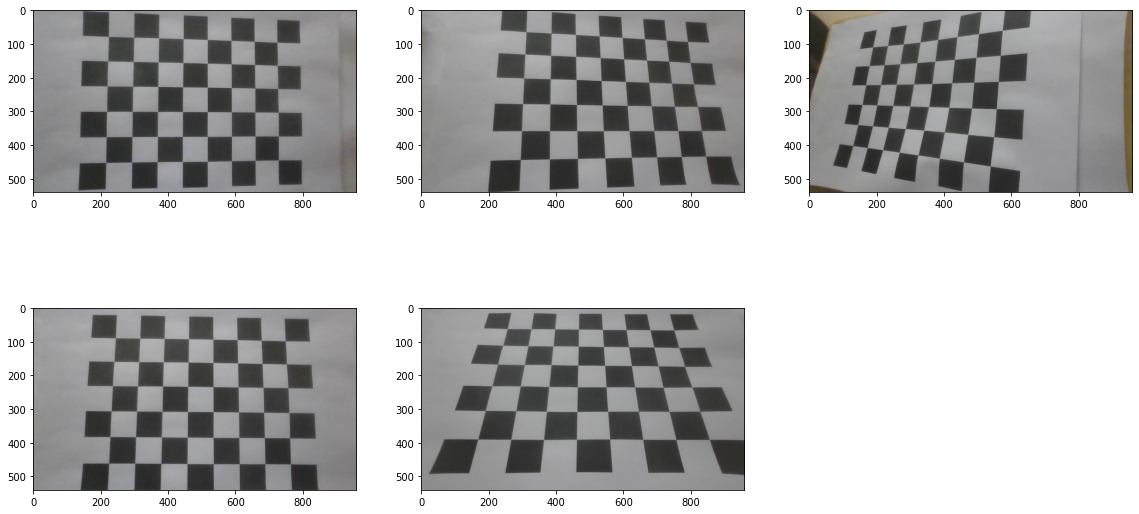

Done


In [ ]:
# undistort the image with the calibration
plt.figure(figsize=figsize)
for i, fn in enumerate(img_names):

    imgBGR = cv2.imread(fn)
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)

    dst = cv2.undistort(imgRGB, camera_matrix, dist_coefs)

    if i < 12:
        plt.subplot(4, 3, i + 1)
        plt.imshow(dst)

plt.show()
print("Done")



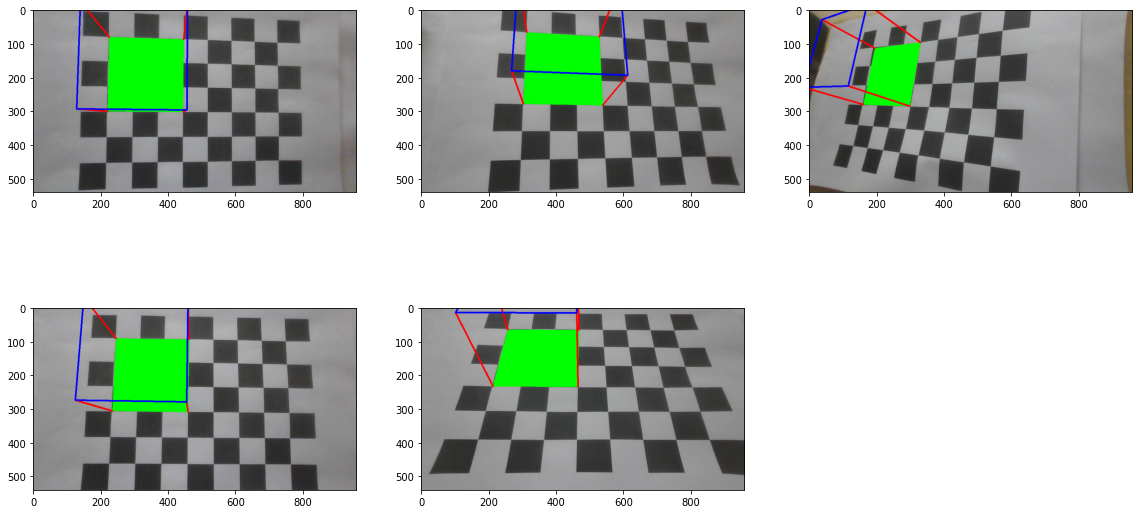

In [ ]:
objectPoints = (
    3
    * square_size
    * np.array([[0, 0, 0], [0, 1, 0], [1, 1, 0], [1, 0, 0], [0, 0, -1], [0, 1, -1], [1, 1, -1], [1, 0, -1]])
)


def draw(img, imgpts):
    imgpts = np.int32(imgpts).reshape(-1, 2)

    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]], -1, (0, 255, 0), -1)

    # draw pillars in blue color
    for i, j in zip(range(4), range(4, 8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (255), 3)

    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]], -1, (0, 0, 255), 3)

    return img


plt.figure(figsize=figsize)
for i, fn in enumerate(img_names):

    imgBGR = cv2.imread(fn)
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)

    dst = cv2.undistort(imgRGB, camera_matrix, dist_coefs)

    imgpts = cv2.projectPoints(objectPoints, _rvecs[i], _tvecs[i], camera_matrix, dist_coefs)[0]
    drawn_image = draw(dst, imgpts)

    if i < 12:
        plt.subplot(4, 3, i + 1)
        plt.imshow(drawn_image)

plt.show()
